**Set-up instructions:** this notebook give a tutorial on the forecasting learning task supported by `sktime`.
On binder, this should run out-of-the-box.

To run this notebook as intended, ensure that `sktime` with basic dependency requirements is installed in your python environment.

To run this notebook with a local development version of sktime, an editable developer installation is recommended, see the [sktime developer install guide](https://www.sktime.org/en/stable/installation.html#development-versions) for instructions.

# Forecasting with sktime

In forecasting, past data is used to make temporal forward predictions of a time series. This is notably different from tabular prediction tasks supported by `scikit-learn` and similar libraries.


<img src="img/forecasting.png" width=750 />

`sktime` provides a common, `scikit-learn`-like interface to a variety of classical and ML-style forecasting algorithms, together with tools for building pipelines and composite machine learning models, including temporal tuning schemes, or reductions such as walk-forward application of `scikit-learn` regressors.

**Section 1** provides an overview of common forecasting workflows supported by `sktime`.

**Section 2** discusses the families of forecasters available in `sktime`.

**Section 3** discusses advanced composition patterns, including pipeline building, reduction, tuning, ensembling, and autoML.

**Section 4** gives an introduction to how to write custom estimators compliant with the `sktime` interface.

Further references:
* For further details on how forecasting is different from supervised prediction à la `scikit-learn`, and pitfalls of misdiagnosing forecasting as supervised prediction, have a look at [this notebook](./01a_forecasting_sklearn.ipynb)
* For a scientific reference, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss `sktime`'s forecasting module in more detail and use it to replicate and extend the M4 study.

## Table of Contents

* [1. Basic forecasting workflows](#chapter1)
    * [1.1 Data container format](#section_1_1)
    * [1.2 Basic deployment workflow - batch fitting and forecasting](#section_1_2)
        * [1.2.1 Basic deployment workflow in a nutshell](#section_1_2_1)
        * [1.2.2 Forecasters that require the horizon already in `fit`](#section_1_2_2)
        * [1.2.3 Forecasters that can make use of exogeneous data](#section_1_2_3)
        * [1.2.4 Multivariate Forecasters](#section_1_2_4)
        * [1.2.5 Prediction intervals and quantile forecasts](#section_1_2_5)  
        * [1.2.6 Panel forecasts and hierarchical forecasts](#section_1_2_6)    
    * [1.3 Basic evaluation workflow - evaluating a batch of forecasts against ground truth observations](#section_1_3)   
        * [1.3.1 The basic batch forecast evaluation workflow in a nutshell - function metric interface](#section_1_3_1)
        * [1.3.2 The basic batch forecast evaluation workflow in a nutshell - metric class interface](#section_1_3_2)           
    * [1.4 Advanced deployment workflow: rolling updates & forecasts](#section_1_4) 
        * [1.4.1 Updating a forecaster with the update method](#section_1_4_1)    
        * [1.4.2 Moving the "now" state without updating the model](#section_1_4_2)   
        * [1.4.3 Walk-forward predictions on a batch of data](#section_1_4_3)  
    * [1.5 Advanced evaluation worfklow: rolling re-sampling and aggregate errors, rolling back-testing](#section_1_5)         
* [2. Forecasters in sktime - searching, tags, common families](#chapter2)
    * [2.1 Forecaster lookup - the registry](#section_2_1)
    * [2.2 Forecaster tags](#section_2_2)
        * [2.2.1 Capability tags: multivariate, probabilistic, hierarchical](#section_2_2_1)
        * [2.2.2 Finding and listing forecasters by tag](#section_2_2_2)
        * [2.2.3 Listing all forecaster tags](#section_2_2_3)
    * [2.3 Common forecaster types](#section_2_3)
        * [2.3.1 Exponential smoothing, theta forecaster, autoETS from statsmodels](#section_2_3_1)
        * [2.3.2 ARIMA and autoARIMA](#section_2_3_2)
        * [2.3.3 BATS and TBATS](#section_2_3_3)    
        * [2.3.4 Facebook prophet](#section_2_3_4)  
        * [2.3.5 State Space Model (Structural Time Series)](#section_2_3_5)  
        * [2.3.6 AutoArima from StatsForecast](#section_2_3_6)  
* [3. Advanced composition patterns - pipelines, reduction, autoML, and more](#chapter3)
    * [3.1 Reduction: from forecasting to regression](#section_3_1)
    * [3.2 Pipelining, detrending and deseasonalization](#section_3_2)    
        * [3.2.1 The basic forecasting pipeline](#section_3_2_1)
        * [3.2.2 The Detrender as pipeline component](#section_3_2_2) 
        * [3.2.3 Complex pipeline composites and parameter inspection](#section_3_2_3)        
    * [3.3 Parameter tuning](#section_3_3)      
        * [3.3.1 Basic tuning using ForecastingGridSearchCV](#section_3_3_1)  
        * [3.3.2 Tuning of complex composites](#section_3_3_2)        
        * [3.3.3 Selecting the metric and retrieving scores](#section_3_3_3) 
    * [3.4 autoML aka automated model selection, ensembling and hedging](#section_3_4) 
        * [3.4.1 autoML aka automatic model selection, using tuning plus multiplexer](#section_3_4_1)   
        * [3.4.2 autoML: selecting transformer combinations via OptimalPassthrough](#section_3_4_2)  
        * [3.4.3 Simple ensembling strategies](#section_3_4_3)   
        * [3.4.4 Prediction weighted ensembles and hedge ensembles](#section_3_4_4)  
* [4. Extension guide - implementing your own forecaster](#chapter4)        
* [5. Summary](#chapter5)          

#### Package imports

In [102]:
import warnings

import numpy as np
import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

## 1. Basic forecasting workflows <a class="anchor" id="chapter1"></a>

This section explains the basic forecasting workflows, and key interface points for it.

We cover the following four workflows:

* Basic deployment workflow: batch fitting and forecasting
* Basic evaluation workflow: evaluating a batch of forecasts against ground truth observations
* Advanced deployment workflow: fitting and rolling updates/forecasts
* Advanced evaluation worfklow: using rolling forecast splits and computing split-wise and aggregate errors, including common back-testing schemes

### 1.1 Data container format<a class="anchor" id="section_1_1"></a>

All workflows make common assumptions on the input data format.

`sktime` uses `pandas` for representing time series:

* `pd.DataFrame` for time series and sequences, primarily. Rows represent time indices, columns represent variables.
* `pd.Series` can also be used for univariate time series and sequences
* `numpy` arrays (1D and 2D) can also be passed, but `pandas` use is encouraged.

The `Series.index` and `DataFrame.index` are used for representing the time series or sequence index.
`sktime` supports pandas integer, period and timestamp indices for simple time series.

`sktime` supports further, additional container formats for panel and hierarchical time series, these are discussed in Section 1.6.

**Example:** as the running example in this tutorial, we use a textbook data set, the Box-Jenkins airline data set, which consists of the number of monthly totals of international airline passengers, from 1949 - 1960. Values are in thousands. See "Makridakis, Wheelwright and Hyndman (1998) Forecasting: methods and applications", exercises sections 2 and 3.

In [103]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

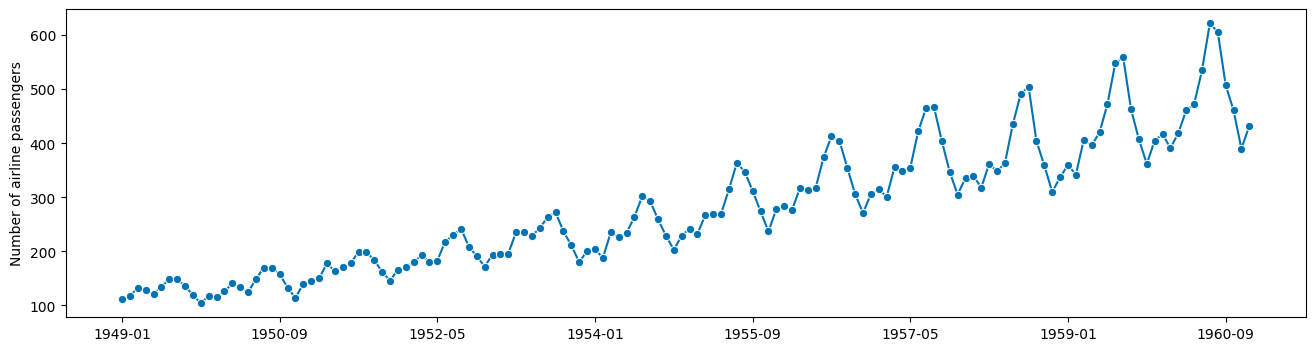

In [104]:
y = load_airline()

# plotting for visualization
plot_series(y)

In [105]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144)

Generally, users are expected to use the in-built loading functionality of `pandas` and `pandas`-compatible packages to load data sets for forecasting, such as `read_csv` or the `Series` or `DataFrame` constructors if data is available in another in-memory format, e.g., `numpy.array`.

`sktime` forecasters may accept input in `pandas`-adjacent formats, but will produce outputs in, and attempt to coerce inputs to, `pandas` formats.

NOTE: if your favourite format is not properly converted or coerced, kindly consider to contribute that functionality to `sktime`.

### 1.2 Basic deployment workflow - batch fitting and forecasting<a class="anchor" id="section_1_2"></a>

The simplest use case workflow is batch fitting and forecasting, i.e., fitting a forecasting model to one batch of past data, then asking for forecasts at time point in the future.

The steps in this workflow are as follows:

1. Preparation of the data
2. Specification of the time points for which forecasts are requested. This uses a `numpy.array` or the `ForecastingHorizon` object.
3. Specification and instantiation of the forecaster. This follows a `scikit-learn`-like syntax; forecaster objects follow the familiar `scikit-learn` `BaseEstimator` interface.
4. Fitting the forecaster to the data, using the forecaster's `fit` method
5. Making a forecast, using the forecaster's `predict` method

The below first outlines the vanilla variant of the basic deployment workflow, step-by-step.

At the end, one-cell workflows are provided, with common deviations from the pattern (Sections 1.2.1 and following).

#### Step 1 - Preparation of the data

As discussed in Section 1.1, the data is assumed to be in `pd.Series` or `pd.DataFrame` format.

In [106]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

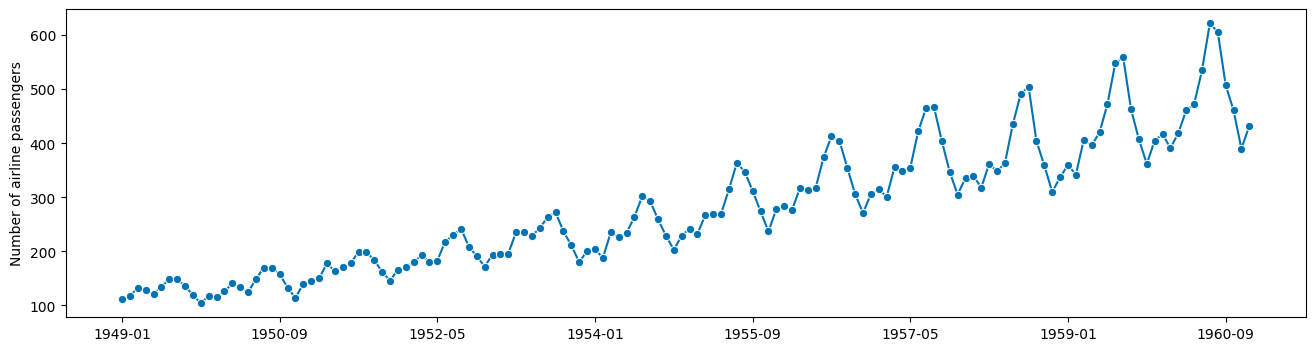

In [107]:
# in the example, we use the airline data set.
y = load_airline()
plot_series(y)

#### Step 2 - Specifying the forecasting horizon

Now we need to specify the forecasting horizon and pass that to our forecasting algorithm.

There are two main ways:

* Using a `numpy.array` of integers. This assumes either integer index or periodic index (`PeriodIndex`) in the time series; the integer indicates the number of time points or periods ahead we want to make a forecast for. E.g., `1` means forecast the next period, `2` the second next period, and so on.
* Using a `ForecastingHorizon` object. This can be used to define forecast horizons, using any supported index type as an argument. No periodic index is assumed.

Forecasting horizons can be absolute, i.e., referencing specific time points in the future, or relative, i.e., referencing time differences to the present. As a default, the present is that latest time point seen in any `y` passed to the forecaster.

`numpy.array` based forecasting horizons are always relative; `ForecastingHorizon` objects can be both relative and absolute. In particular, absolute forecasting horizons can only be specified using `ForecastingHorizon`.

##### Using a `numpy` forecasting horizon

In [108]:
fh = np.arange(1, 37)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

This will ask for monthly predictions for the next three years, since the original series period is 1 month.
In another example, to predict only the second and fifth month ahead, one could write:

```python
import numpy as np
fh = np.array([2, 5])  # 2nd and 5th step ahead
```

##### Using a `ForecastingHorizon` based forecasting horizon

The `ForecastingHorizon` object takes absolute indices as input, but considers the input absolute or relative depending on the `is_relative` flag.

`ForecastingHorizon` will automatically assume a relative horizon if temporal difference types from `pandas` are passed; if value types from `pandas` are passed, it will assume an absolute horizon.

To define an absolute `ForecastingHorizon` in our example:

In [109]:
from sktime.forecasting.base import ForecastingHorizon

In [110]:
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

`ForecastingHorizon`-s can be converted from relative to absolute and back via the `to_relative` and `to_absolute` methods. Both of these conversions require a compatible `cutoff` to be passed:

In [111]:
cutoff = pd.Period("1960-12", freq="M")

In [112]:
fh.to_relative(cutoff)

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', is_relative=True)

In [113]:
fh.to_absolute(cutoff)

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

#### Step 3 - Specifying the forecasting algorithm

To make forecasts, a forecasting algorithm needs to be specified. This is done using a `scikit-learn`-like interface. Most importantly, all `sktime` forecasters follow the same interface, so the preceding and remaining steps are the same, no matter which forecaster is being chosen.

For this example, we choose the naive forecasting method of predicting the last seen value. More complex specifications are possible, using pipeline and reduction construction syntax; this will be covered later in Section 2.

In [114]:
from sktime.forecasting.naive import NaiveForecaster

In [115]:
forecaster = NaiveForecaster(strategy="last")

#### Step 4 - Fitting the forecaster to the seen data

Now the forecaster needs to be fitted to the seen data:

In [116]:
forecaster.fit(y)

NaiveForecaster()

#### Step 5 - Requesting forecasts

Finally, we request forecasts for the specified forecasting horizon. This needs to be done after fitting the forecaster:

In [117]:
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

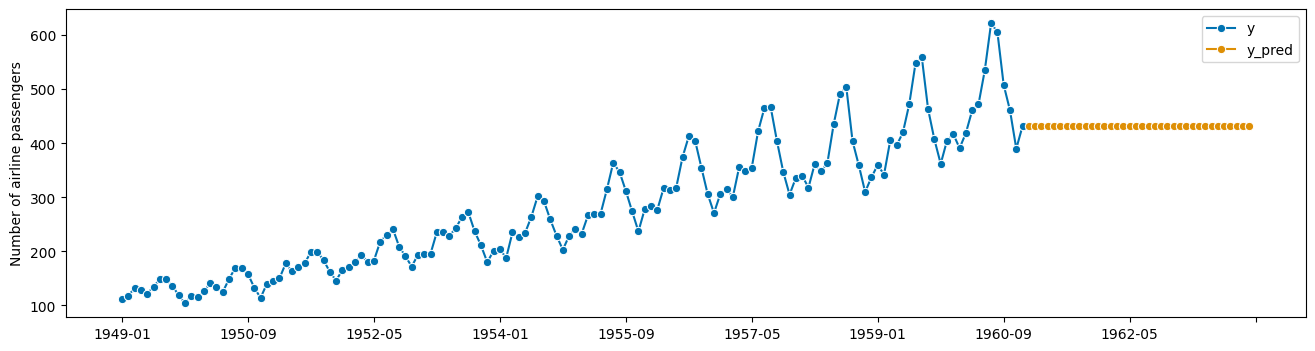

In [118]:
# plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

#### 1.2.1 The basic deployment workflow in a nutshell<a class="anchor" id="section_1_2_1"></a>

For convenience, we present the basic deployment workflow in one cell.
This uses the same data, but different forecaster: predicting the latest value observed in the same month.

In [119]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [120]:
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

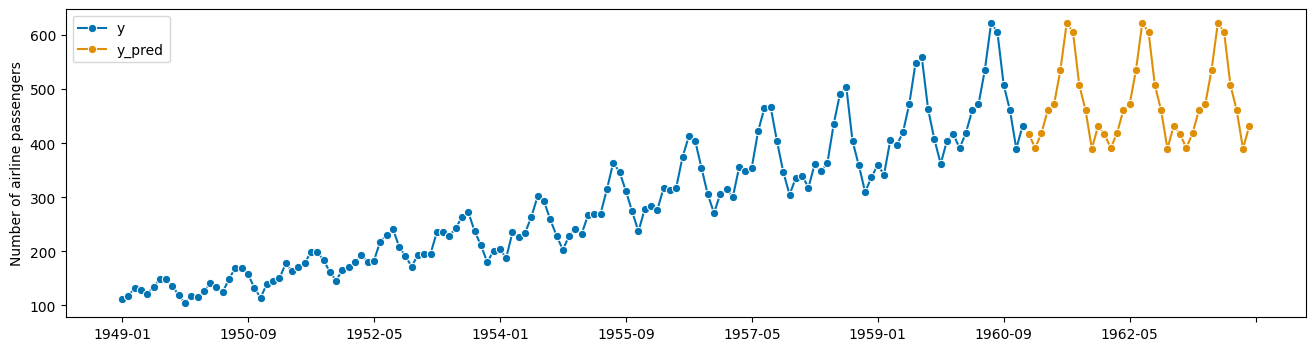

In [121]:
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

#### 1.2.2 Forecasters that require the horizon already in `fit` <a class="anchor" id="section_1_2_2"></a>

Some forecasters need the forecasting horizon provided already in `fit`. Such forecasters will produce informative error messages when it is not passed in `fit`. All forecaster will remember the horizon when already passed in `fit` for prediction. The modified workflow to allow for such forecasters in addition is as follows:

In [122]:
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict()

#### 1.2.3 Forecasters that can make use of exogeneous data<a class="anchor" id="section_1_2_3"></a>

Many forecasters can make use of exogeneous time series, i.e., other time series that are not forecast, but are useful for forecasting `y`. Exogeneous time series are always passed as an `X` argument, in `fit`, `predict`, and other methods (see below). Exogeneous time series should always be passed as `pandas.DataFrames`. Most forecasters that can deal with exogeneous time series will assume that the time indices of `X` passed to `fit` are a super-set of the time indices in `y` passed to `fit`; and that the time indices of `X` passed to `predict` are a super-set of time indices in `fh`, although this is not a general interface restriction. Forecasters that do not make use of exogeneous time series still accept the argument (and do not use it internally).

The general workflow for passing exogeneous data is as follows:

In [123]:
# step 1: data specification
y = load_airline()
# we create some dummy exogeneous data
X = pd.DataFrame(index=y.index)

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, X=X, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict(X=X)

NOTE: as in workflows 1.2.1 and 1.2.2, some forecasters that use exogeneous variables may also require the forecasting horizon only in `predict`. Such forecasters may also be called with steps 4 and 5 being
```python
forecaster.fit(y, X=X)
y_pred = forecaster.predict(fh=fh, X=X)
```

#### 1.2.4. Multivariate forecasting <a class="anchor" id="section_1_2_4"></a>

All forecasters in `sktime` support multivariate forecasts - some forecasters are "genuine" multivariate, all others "apply by column".

Below is an example of the general multivariate forecasting workflow, using the `VAR` (vector auto-regression) forecaster on the Longley dataset from `sktime.datasets`. The workflow is the same as in the univariate forecasters, but the input has more than one variables (columns).

In [124]:
from sktime.datasets import load_longley
from sktime.forecasting.var import VAR

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()

The input to the multivariate forecaster `y` is a `pandas.DataFrame` where each column is a variable.

In [125]:
y

,GNPDEFL,GNP
Period,,
1947,83.0,234289.0
1948,88.5,259426.0
1949,88.2,258054.0
1950,89.5,284599.0
1951,96.2,328975.0
1952,98.1,346999.0
1953,99.0,365385.0
1954,100.0,363112.0
1955,101.2,397469.0


The result of the multivariate forecaster `y_pred` is a `pandas.DataFrame` where columns are the predicted values for each variable. The variables in `y_pred` are the same as in `y`, the input to the multivariate forecaster.

In [126]:
y_pred

,GNPDEFL,GNP
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


As said above, all forecasters accept multivariate input and will produce multivariate forecasts.
There are two categories:

* forecasters that are genuinely multivariate, such as `VAR`. Forecasts for one endogeneous (`y`) variable will depend on values of other variables.
* forecasters that are univariate, such as `ARIMA`. Forecasts will be made by endogeneous (`y`) variable, and not be affected by other variables.

To display complete list of multivariate forecasters, search for forecasters with `'multivariate'` or `'both'` tag value for the tag `'scitype:y'`, as follows:

In [127]:
from sktime.registry import all_estimators

for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
    print(forecaster[0])

Univariate forecasters have tag value `'univariate'`, and will fit one model per column.
To access the column-wise models, access the `forecasters_` parameter, which stores the fitted forecasters in a `pandas.DataFrame`, fitted forecasters being in the column with the variable for which the forecast is being made:

In [128]:
from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = ARIMA()
forecaster.fit(y, fh=[1, 2, 3])

forecaster.forecasters_

,GNPDEFL,GNP
forecasters,ARIMA(),ARIMA()


#### 1.2.5 Probabilistic forecasting: prediction intervals, quantile, variance, and distributional forecasts <a class="anchor" id="section_1_2_5"></a>

`sktime` provides a unified interface to make probabilistic forecasts.
The following methods are possibly available for probabilistic forecasts:

* `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
* `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
* `predict_var` produces variance forecasts. This has same arguments as `predict`.
* `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

Not all forecasters are capable of returning probabilistic forecast, but if a forecasters provides one kind of probabilistic forecast, it is also capable of returning the others. The list of forecasters with such capability can be queried by `registry.all_estimators`, searching for those where the `capability:pred_int` tag has value`True`.

The basic worfklow for probabilistic forecasts is similar to the basic forecasting workflow, with the difference that instead of `predict`, one of the probabilistic forecasting methods is used:


In [129]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

# until fit, identical with the simple workflow
y = load_airline()

fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

Now we present the different probabilistic forecasting methods.

##### `predict_interval` - interval predictions

`predict_interval` takes an argument `coverage`, which is a float (or list of floats), the nominal coverage of the prediction interval(s) queried. `predict_interval` produces symmetric prediction intervals, for example, a coverage of `0.9` returns a "lower" forecast at quantile `0.5 - coverage/2 = 0.05`, and an "upper" forecast at quantile `0.5 + coverage/2 = 0.95`.

In [130]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Coverage            
                0.9            
              lower       upper
1961-01  418.280121  464.281951
1961-02  402.215881  456.888055
1961-03  459.966113  522.110500
1961-04  442.589309  511.399214
1961-05  443.525027  518.409480
1961-06  506.585814  587.087737
1961-07  561.496768  647.248956
1961-08  557.363322  648.062363
1961-09  477.658056  573.047752
1961-10  407.915090  507.775355
1961-11  346.942924  451.082016
1961-12  394.708221  502.957142

The return `y_pred_ints` is a `pandas.DataFrame` with a column multi-index: The first level is variable name from `y` in fit (or `Coverage` if no variable names were present), second level coverage fractions for which intervals were computed, in the same order as in input `coverage`; third level columns `lower` and `upper`. Rows are the indices for which forecasts were made (same as in `y_pred` or `fh`). Entries are lower/upper (as column name) bound of the nominal coverage predictive interval for the index in the same row. 

Pretty-plotting the predictive interval forecasts:

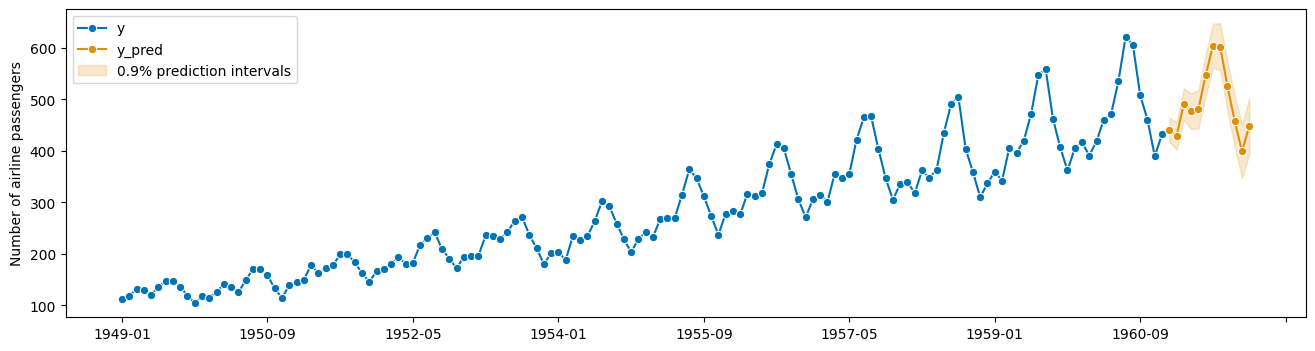

In [131]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
)

##### `predict_quantiles` - quantile forecasts

sktime offers `predict_quantiles` as a unified interface to return quantile values of predictions. Similar to `predict_interval`.

`predict_quantiles` has an argument `alpha`, containing the quantile values being queried. Similar to the case of the `predict_interval`, `alpha` can be a `float`, or a `list of floats`. 

In [132]:
y_pred_quantiles = forecaster.predict_quantiles(alpha=[0.275, 0.975])
y_pred_quantiles

Quantiles            
              0.275       0.975
1961-01  432.922219  468.688317
1961-02  419.617696  462.124925
1961-03  479.746287  528.063109
1961-04  464.491077  517.990291
1961-05  467.360286  525.582418
1961-06  532.209079  594.798754
1961-07  588.791160  655.462879
1961-08  586.232267  656.750129
1961-09  508.020007  582.184821
1961-10  439.699996  517.340645
1961-11  380.089754  461.057161
1961-12  429.163184  513.325954

`y_pred_quantiles`, the output of predict_quantiles, is a `pandas.DataFrame` with a two-level column multiindex. The first level is variable name from `y` in fit (or `Quantiles` if no variable names were present), second level are the quantile values (from `alpha`) for which quantile predictions were queried. Rows are the indices for which forecasts were made (same as in `y_pred` or `fh`). Entries are the quantile predictions for that variable, that quantile value, for the time index in the same row.

Remark: for clarity: quantile and (symmetric) interval forecasts can be translated into each other as follows.

**alpha < 0.5:** The alpha-quantile prediction is equal to the lower bound of a predictive interval with coverage = (0.5 - alpha) * 2

**alpha > 0.5:** The alpha-quantile prediction is equal to the upper bound of a predictive interval with coverage = (alpha - 0.5) * 2

##### `predict_var` - variance predictions

`predict_var` produces variance predictions:

In [133]:
y_pred_var = forecaster.predict_var()
y_pred_var

,0
1961-01,195.540049
1961-02,276.196509
1961-03,356.852968
1961-04,437.509428
1961-05,518.165887
1961-06,598.822347
1961-07,679.478807
1961-08,760.135266
1961-09,840.791726
1961-10,921.448185


The format of the output `y_pred_var` is the same as for `predict`, except that this is always coerced to a `pandas.DataFrame`, and entries are not point predictions but variance predictions.

##### `predict_proba` - distribution predictions

To predict full predictive distributions, `predict_proba` can be used.
As this returns `tensorflow` `Distribution` objects, the deep learning dependency set `dl` of `sktime` (which includes `tensorflow` and `tensorflow-probability` dependencies) must be installed.

In [134]:
y_pred_proba = forecaster.predict_proba()
y_pred_proba

2022-12-03 14:10:56.017813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 14:11:20.412369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tfp.distributions.Normal 'Normal' batch_shape=[12, 1] event_shape=[] dtype=float32>

Distributions returned by `predict_proba` are by default marginal at time points, not joint over time points.
More precisely, the returned `Distribution` object is formatted and to be interpreted as follows:
* Batch shape is 1D and same length as fh
* Event shape is 1D, with length equal to number of variables being forecast
* i-th (batch) distribution is forecast for i-th entry of fh
* j-th (event) component is j-th variable, same order as y in `fit`/`update`

To return joint forecast distributions, the `marginal` parameter can be set to `False` (currently work in progress). In this case, a `Distribution` with 2D event shape `(len(fh), len(y))` is returned.

#### 1.2.6 Panel forecasts and hierarchical forecasts <a class="anchor" id="section_1_2_6"></a>

`sktime` provides a unified interface to make panel and hierarchical forecasts.

All `sktime` forecasters can be applied to panel and hierarchical data, which needs to be presented in specific input formats.
Forecasters that are not genuinely panel or hierarchical forecasters will be applied by instance.

The recommended (not the only) format to pass panel and hierarchical data is a `pandas.DataFrame` with `MultiIndex` row. In this `MultiIndex`, the last level must be in an `sktime` compatible time index format, the remaining levels are panel or hierarchy nodes.

Example data:

In [135]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

y = _bottom_hier_datagen(no_levels=2)
y

passengers
l2_agg    l1_agg    timepoints              
l2_node01 l1_node04 1949-01       686.172966
                    1949-02       722.238081
                    1949-03       806.485645
                    1949-04       788.421584
                    1949-05       740.280000
...                                      ...
l2_node03 l1_node06 1960-08     11231.410000
                    1960-09      9416.450000
                    1960-10      8546.010000
                    1960-11      7231.090000
                    1960-12      8008.930000

[864 rows x 1 columns]

As stated, all forecasters, genuinely hierarchical or not, can be applied, with all workflows described in this section, to produce hierarchical forecasts.

The syntax is exactly the same as for plain time series, except for the hierarchy levels in input and output data:

In [136]:
from sktime.forecasting.arima import ARIMA

fh = [1, 2, 3]

forecaster = ARIMA()
forecaster.fit(y, fh=fh)
forecaster.predict()

passengers
l2_agg    l1_agg    timepoints              
l2_node01 l1_node04 1961-01      2602.369637
                    1961-02      2569.840477
                    1961-03      2538.478587
l2_node02 l1_node05 1961-01      6976.238440
                    1961-02      6816.300900
                    1961-03      6665.893528
l2_node03 l1_node01 1961-01       426.544850
                    1961-02       421.282983
                    1961-03       416.207550
          l1_node02 1961-01     20170.899333
                    1961-02     19643.979448
                    1961-03     19150.644037
          l1_node03 1961-01      3910.706081
                    1961-02      3862.514055
                    1961-03      3816.029080
          l1_node06 1961-01      7907.955225
                    1961-02      7810.556114
                    1961-03      7716.606045

Similar to multivariate forecasting, forecasters that are not genuinely hierarchical fit by instance.
The forecasters fitted by instance can be accessed in the `forecasters_` parameter, which is a `pandas.DataFrame` where forecasters for a given instance are placed in the row with the index of the instance for which they make forecasts:

In [137]:
forecaster.forecasters_

forecasters
l2_agg    l1_agg               
l2_node01 l1_node04     ARIMA()
l2_node02 l1_node05     ARIMA()
l2_node03 l1_node01     ARIMA()
          l1_node02     ARIMA()
          l1_node03     ARIMA()
          l1_node06     ARIMA()

If the data is both hierarchical and multivariate, and the forecaster cannot genuinely deal with either, the `forecasters_` attribute will have both column indices, for variables, and row indices, for instances, with forecasters fitted per instance and variable:

In [138]:
from sktime.forecasting.arima import ARIMA
from sktime.utils._testing.hierarchical import _make_hierarchical

y = _make_hierarchical(n_columns=2)

fh = [1, 2, 3]

forecaster = ARIMA()
forecaster.fit(y, fh=fh)

forecaster.forecasters_

c0       c1
h0   h1                    
h0_0 h1_0  ARIMA()  ARIMA()
     h1_1  ARIMA()  ARIMA()
     h1_2  ARIMA()  ARIMA()
     h1_3  ARIMA()  ARIMA()
h0_1 h1_0  ARIMA()  ARIMA()
     h1_1  ARIMA()  ARIMA()
     h1_2  ARIMA()  ARIMA()
     h1_3  ARIMA()  ARIMA()

Further details on hierarchical forecasting, including reduction, aggregation, reconciliation, are presented in the "hierarchical forecasting" tutorial.

### 1.3 Basic evaluation workflow - evaluating a batch of forecasts against ground truth observations<a class="anchor" id="section_1_3"></a>

It is good practice to evaluate statistical performance of a forecaster before deploying it, and regularly re-evaluate performance if in continuous deployment. The evaluation workflow for the basic batch forecasting task, as solved by the workflow in Section 1.2, consists of comparing batch forecasts with actuals. This is sometimes called (batch-wise) backtesting.

The basic evaluation workflow is as follows:

1. Splitting a representatively chosen historical series into a temporal training and test set. The test set should be temporally in the future of the training set.
2. Obtaining batch forecasts, as in Section 1.2, by fitting a forecaster to the training set, and querying predictions for the test set
3. Specifying a quantitative performance metric to compare the actual test set against predictions
4. Computing the quantitative performance on the test set
5. Testing whether this performance is statistically better than a chosen baseline performance

NOTE: Step 5 (testing) is currently not supported in `sktime`, but is on the development roadmap. For the time being, it is advised to use custom implementations of appropriate methods (e.g., Diebold-Mariano test; stationary confidence intervals).

NOTE: Note that this evaluation set-up determines how well a given algorithm would have performed on past data. Results are only insofar representative as future performance can be assumed to mirror past performance. This can be argued under certain assumptions (e.g., stationarity), but will in general be false. Monitoring of forecasting performance is hence advised in case an algorithm is applied multiple times.

**Example:** In the example, we will us the same airline data as in Section 1.2. But, instead of predicting the next 3 years, we hold out the last 3 years of the airline data (below: `y_test`), and see how the forecaster would have performed three years ago, when asked to forecast the most recent 3 years (below: `y_pred`), from the years before (below: `y_train`). "how" is measured by a quantitative performance metric (below: `mean_absolute_percentage_error`). This is then considered as an indication of how well the forecaster would perform in the coming 3 years (what was done in Section 1.2). This may or may not be a stretch depending on statistical assumptions and data properties (caution: it often is a stretch - past performance is in general not indicative of future performance).

#### Step 1 - Splitting a historical data set in to a temporal train and test batch

In [139]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [140]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train

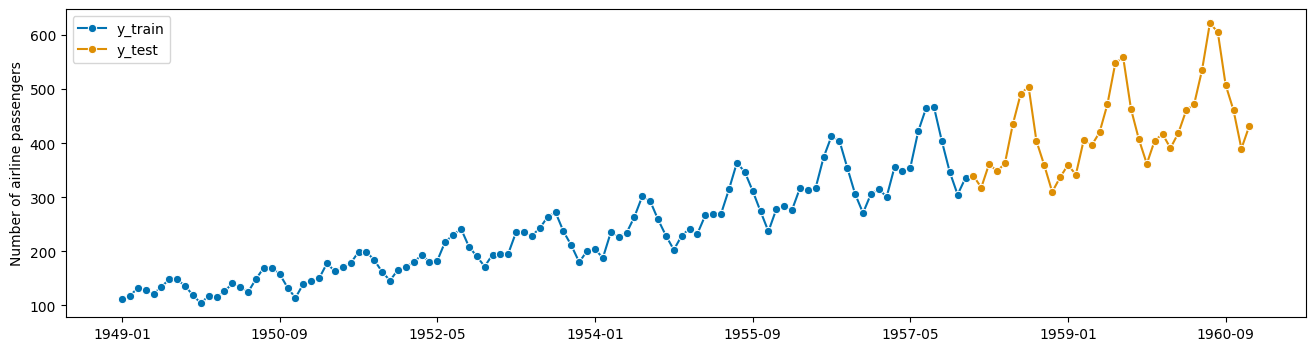

In [141]:
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

#### Step 2 - Making forecasts for y_test from y_train

This is almost verbatim the workflow in Section 1.2, using `y_train` to predict the indices of `y_test`.

In [142]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

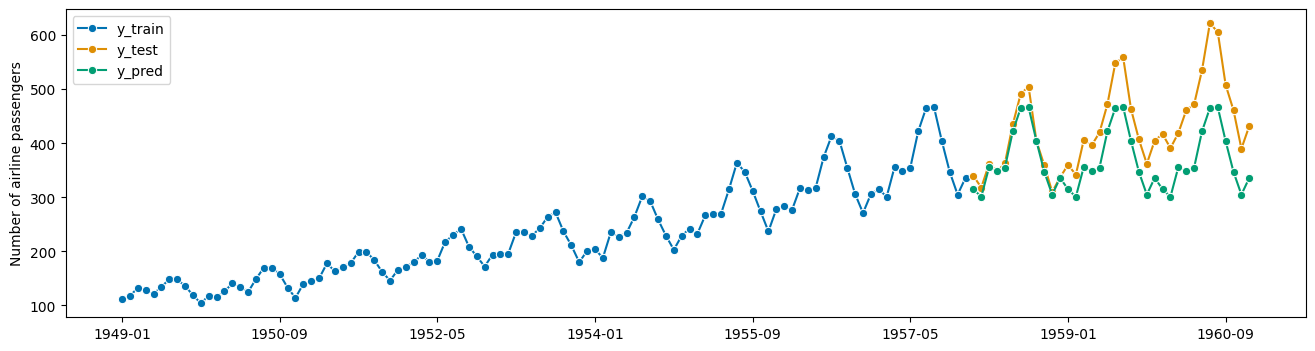

In [143]:
# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

#### Steps 3 and 4 - Specifying a forecasting metric, evaluating on the test set

The next step is to specify a forecasting metric. These are functions that return a number when input with prediction and actual series. They are different from `sklearn` metrics in that they accept series with indices rather than `np.array`s. Forecasting metrics can be invoked in two ways:

* using the lean function interface, e.g., `mean_absolute_percentage_error` which is a python function `(y_true : pd.Series, y_pred : pd.Series) -> float`
* using the composable class interface, e.g., `MeanAbsolutePercentageError`, which is a python class, callable with the same signature

Casual users may opt to use the function interface. The class interface supports advanced use cases, such as parameter modification, custom metric composition, tuning over metric parameters (not covered in this tutorial)

In [144]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [145]:
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
# note: the FIRST argument is the ground truth, the SECOND argument are the forecasts
#       the order matters for most metrics in general

0.13189432350948402

To properly interpret numbers like this, it is useful to understand properties of the metric in question (e.g., lower is better), and to compare against suitable baselines and contender algorithms (see step 5).

In [146]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [147]:
# option 2: using the composable class interface
mape = MeanAbsolutePercentageError(symmetric=False)
# the class interface allows to easily construct variants of the MAPE
#  e.g., the non-symmetric verion
# it also allows for inspection of metric properties
#  e.g., are higher values better (answer: no)?
mape.get_tag("lower_is_better")

True

In [148]:
# evaluation works exactly like in option 2, but with the instantiated object
mape(y_test, y_pred)

0.13189432350948402

NOTE: Some metrics, such as `mean_absolute_scaled_error`, also require the training set for evaluation. In this case, the training set should be passed as a `y_train` argument. Refer to the API reference on individual metrics.

NOTE: The workflow is the same for forecasters that make use of exogeneous data - no `X` is passed to the metrics.

#### Step 5 - Testing performance against benchmarks

In general, forecast performances should be quantitatively tested against benchmark performances.

Currently (`sktime` v0.12.x), this is a roadmap development item. Contributions are very welcome.

#### 1.3.1 The basic batch forecast evaluation workflow in a nutshell - function metric interface<a class="anchor" id="section_1_3_1"></a>

For convenience, we present the basic batch forecast evaluation workflow in one cell.
This cell is using the lean function metric interface.

In [149]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [150]:
# step 1: splitting historical data
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# step 3: specifying the evaluation metric and
# step 4: computing the forecast performance
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# step 5: testing forecast performance against baseline
# under development

0.13189432350948402

#### 1.3.2 The basic batch forecast evaluation workflow in a nutshell - metric class interface<a class="anchor" id="section_1_3_2"></a>

For convenience, we present the basic batch forecast evaluation workflow in one cell.
This cell is using the advanced class specification interface for metrics.

In [151]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [152]:
# step 1: splitting historical data
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)
# if function interface is used, just use the function directly in step 4

# step 4: computing the forecast performance
mape(y_test, y_pred)

# step 5: testing forecast performance against baseline
# under development

0.13189432350948402

### 1.4 Advanced deployment workflow: rolling updates & forecasts<a class="anchor" id="section_1_4"></a>

A common use case requires the forecaster to regularly update with new data and make forecasts on a rolling basis. This is especially useful if the same kind of forecast has to be made at regular time points, e.g., daily or weekly. `sktime` forecasters support this type of deployment workflow via the `update` and `update_predict` methods.

### 1.4.1 Updating a forecaster with the `update` method<a class="anchor" id="section_1_4_1"></a>

The `update` method can be called when a forecaster is already fitted, to ingest new data and make updated forecasts - this is referred to as an "update step".

After the update, the forecaster's internal "now" state (the `cutoff`) is set to the latest time stamp seen in the update batch (assumed to be later than previously seen data).

The general pattern is as follows:

1. Specify a forecasting strategy
2. Specify a relative forecasting horizon
3. Fit the forecaster to an initial batch of data using `fit`
4. Make forecasts for the relative forecasting horizon, using `predict`
5. Obtain new data; use `update` to ingest new data
6. Make forecasts using `predict` for the updated data
7. Repeat 5 and 6 as often as required

**Example**: suppose that, in the airline example, we want to make forecasts a year ahead, but every month, starting December 1957. The first few months, forecasts would be made as follows:

In [153]:
from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

In [154]:
# we prepare the full data set for convenience
# note that in the scenario we will "know" only part of this at certain time points
y = load_airline()

In [155]:
# December 1957

# this is the data known in December 1957
y_1957Dec = y[:-36]

# step 1: specifying the forecasting strategy
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

# step 2: specifying the forecasting horizon: one year ahead, all months
fh = np.arange(1, 13)

# step 3: this is the first time we use the model, so we fit it
forecaster.fit(y_1957Dec)

# step 4: obtaining the first batch of forecasts for Jan 1958 - Dec 1958
y_pred_1957Dec = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

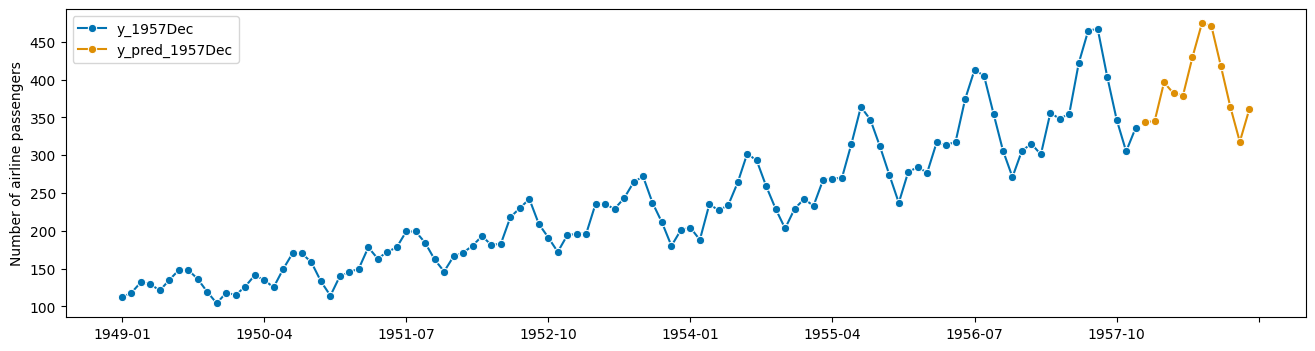

In [156]:
# plotting predictions and past data
plot_series(y_1957Dec, y_pred_1957Dec, labels=["y_1957Dec", "y_pred_1957Dec"])

In [157]:
# January 1958

# new data is observed:
y_1958Jan = y[[-36]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Jan)

# step 6: making forecasts with the updated data
y_pred_1958Jan = forecaster.predict(fh)

In [158]:
# note that the fh is relative, so forecasts are automatically for 1 month later
#  i.e., from Feb 1958 to Jan 1959
y_pred_1958Jan

1958-02    341.518092
1958-03    392.852642
1958-04    378.524976
1958-05    375.665178
1958-06    426.013948
1958-07    470.580314
1958-08    467.113014
1958-09    414.462982
1958-10    360.966402
1958-11    315.211953
1958-12    357.906992
1959-01    363.041653
Freq: M, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

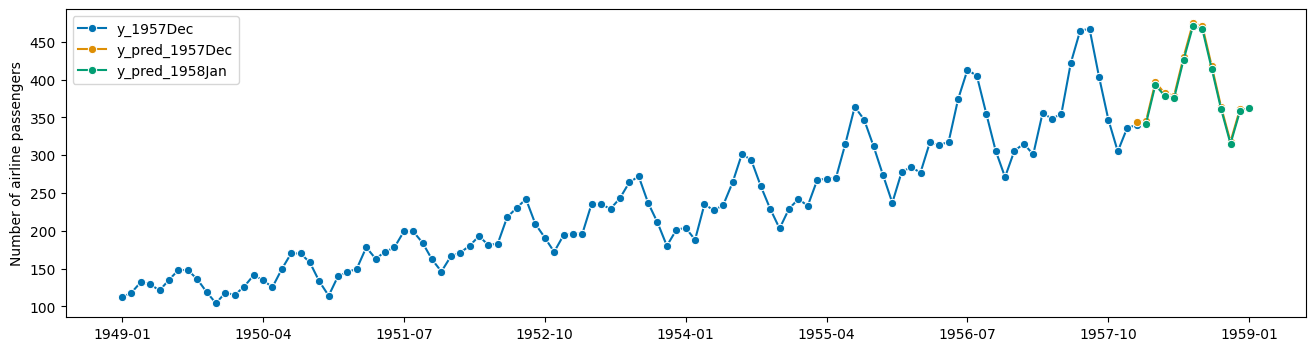

In [159]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan"],
)

In [160]:
# February 1958

# new data is observed:
y_1958Feb = y[[-35]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Feb)

# step 6: making forecasts with the updated data
y_pred_1958Feb = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

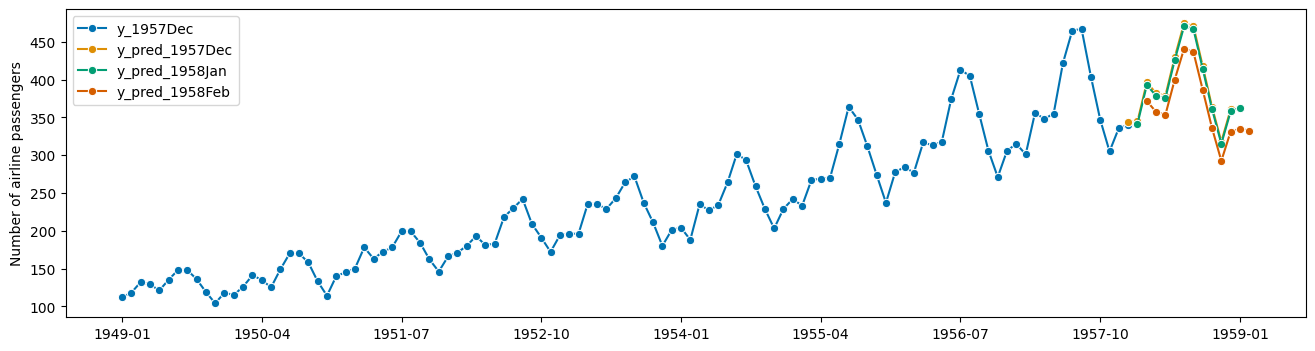

In [161]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    y_pred_1958Feb,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan", "y_pred_1958Feb"],
)

... and so on.

A shorthand for running first `update` and then `predict` is `update_predict_single` - for some algorithms, this may be more efficient than the separate calls to `update` and `predict`:

In [162]:
# March 1958

# new data is observed:
y_1958Mar = y[[-34]]

# step 5&6: update/predict in one step
forecaster.update_predict_single(y_1958Mar, fh=fh)

1958-04    349.161733
1958-05    346.920333
1958-06    394.054912
1958-07    435.845496
1958-08    433.322360
1958-09    384.849639
1958-10    335.540594
1958-11    293.177215
1958-12    333.278828
1959-01    338.596459
1959-02    336.983414
1959-03    388.122274
Freq: M, dtype: float64

### 1.4.2 Moving the "now" state without updating the model<a class="anchor" id="section_1_4_2"></a>

In the rolling deployment mode, may be useful to move the estimator's "now" state (the `cutoff`) to later, for example if no new data was observed, but time has progressed; or, if computations take too long, and forecasts have to be queried.

The `update` interface provides an option for this, via the `update_params` argument of `update` and other update funtions.

If `update_params` is set to `False`, no model update computations are performed; only data is stored, and the internal "now" state (the `cutoff`) is set to the most recent date.

In [163]:
# April 1958

# new data is observed:
y_1958Apr = y[[-33]]

# step 5: perform an update without re-computing the model parameters
forecaster.update(y_1958Apr, update_params=False)

AutoETS(auto=True, n_jobs=-1, sp=12)

### 1.4.3 Walk-forward predictions on a batch of data<a class="anchor" id="section_1_4_3"></a>

`sktime` can also simulate the update/predict deployment mode with a full batch of data.

This is not useful in deployment, as it requires all data to be available in advance; however, it is useful in playback, such as for simulations or model evaluation.

The update/predict playback mode can be called using `update_predict` and a re-sampling constructor which encodes the precise walk-forward scheme.

In [164]:
# from sktime.datasets import load_airline
# from sktime.forecasting.ets import AutoETS
# from sktime.forecasting.model_selection import ExpandingWindowSplitter
# from sktime.utils.plotting import plot_series

NOTE: commented out - this part of the interface is currently undergoing a re-work. Contributions and PR are appreciated.

In [165]:
# for playback, the full data needs to be loaded in advance
# y = load_airline()

In [166]:
# step 1: specifying the forecasting strategy
# forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

# step 2: specifying the forecasting horizon
# fh - np.arange(1, 13)

# step 3: specifying the cross-validation scheme
# cv = ExpandingWindowSplitter()

# step 4: fitting the forecaster - fh should be passed here
# forecaster.fit(y[:-36], fh=fh)

# step 5: rollback
# y_preds = forecaster.update_predict(y, cv)

### 1.5 Advanced evaluation worfklow: rolling re-sampling and aggregate errors, rolling back-testing<a class="anchor" id="section_1_5"></a>

To evaluate forecasters with respect to their performance in rolling forecasting, the forecaster needs to be tested in a set-up mimicking rolling forecasting, usually on past data. Note that the batch back-testing as in Section 1.3 would not be an appropriate evaluation set-up for rolling deployment, as that tests only a single forecast batch. 

The advanced evaluation workflow can be carried out using the `evaluate` benchmarking function.
`evalute` takes as arguments:
- a `forecaster` to be evaluated
- a `scikit-learn` re-sampling strategy for temporal splitting (`cv` below), e.g., `ExpandingWindowSplitter` or `SlidingWindowSplitter`
- a `strategy` (string): whether the forecaster should be always be refitted or just fitted once and then updated

In [167]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

In [168]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.061710,5.071925,0.011473,72,1954-12
1,0.050042,6.697191,0.009391,84,1955-12
2,0.029802,8.017982,0.008528,96,1956-12
3,0.053773,3.052587,0.007937,108,1957-12
4,0.073820,4.135028,0.008529,120,1958-12
5,0.030976,9.787234,0.008369,132,1959-12


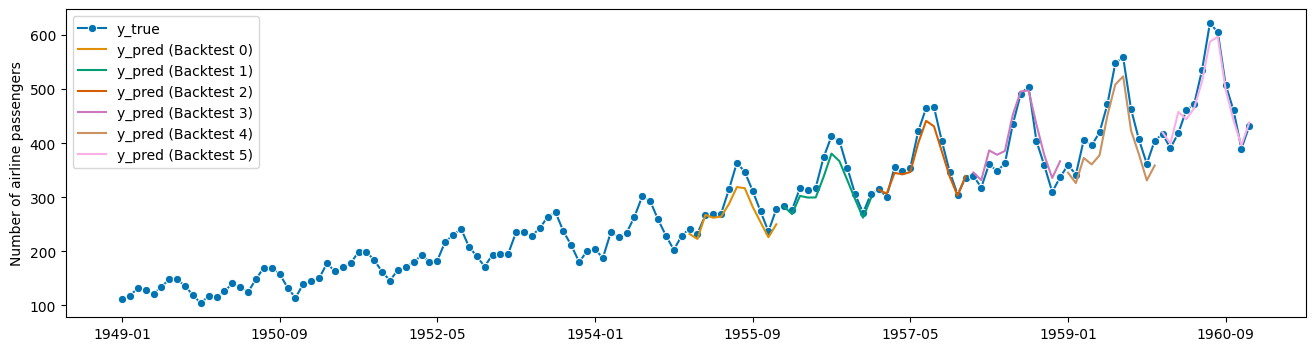

In [169]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

Todo: performance metrics, averages, and testing - contributions to `sktime` and the tutorial are welcome.

## 2. Forecasters in `sktime` - lookup, properties, main families<a class="anchor" id="chapter2"></a>

This section summarizes how to:

* search for forecasters in sktime
* properties of forecasters, corresponding search options and tags
* commonly used types of forecasters in `sktime`

### 2.1 Listing all forecasters in `sktime` <a class="anchor" id="section_2_1"></a>

Generally, all forecasters available in `sktime` can be listed with the `all_estimators` command.

This will list all forecasters in `sktime`, even those whose soft dependencies are not installed.

In [170]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

,name,estimator
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,Croston,<class 'sktime.forecasting.croston.Croston'>


The entries of the last column of the resulting dataframe are classes which could be directly used for construction, or simply inspected for the correct import path.

For logic that loops over forecasters, the default output format may be more convenient:

In [171]:
forecaster_list = all_estimators("forecaster", as_dataframe=False)

# this returns a list of (name, estimator) tuples
forecaster_list[0]

('ARDL', sktime.forecasting.ardl.ARDL)

### 2.2 Forecaster tags <a class="anchor" id="section_2_2"></a>

All forecasters `sktime` have so-called tags which describe properties of the estimator, e.g., whether it is multivariate, probabilistic, or not. Use of tags, inspection, and retrieval will be described in this section.

### 2.2.1 Capability tags: multivariate, probabilistic, hierarchical <a class="anchor" id="section_2_2_1"></a>

Every forecaster has tags, which are key-value pairs that can describe capabilities or internal implementation details.

The most important "capability" style tags are the following:

`requires-fh-in-fit` - a boolean. Whether the forecaster requires the forecasting horizon `fh` already in `fit` (`True`), or whether it can be passed late in `predict` (`False`).

`scitype:y` - a string. Whether the forecaster is univariate (`"univariate"`), strictly multivariate (`"multivariate"`), or can deal with any number of variables (`"both"`).

`capability:pred_int` - a boolean. Whether the forecaster can return probabilistic predictions via `predict_interval` etc, see Section 1.5.

`ignores-exogeneous-X` - a boolean. Whether the forecaster makes use of exogeneous variables `X` (`False`) or not (`True`). If the forecaster does not use `X`, it can still be passed for interface uniformity, and will be ignored.

`handles-missing-data` - a boolean. Whether the forecaster can deal with missing data in the inputs `X` or `y`.

Tags of a forecaster instance can be inspected via the `get_tags` (lists all tags) and `get_tag` (gets value for one tag) methods.

Tag values may depend on hyper-parameter choices.

In [172]:
from sktime.forecasting.arima import ARIMA

ARIMA().get_tags()

{'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:pred_int': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'pmdarima'}

The `y_inner_mtype` and `X_inner_mtype` indicate whether the forecaster can deal with panel or hierarchical data natively - if an panel or hierarchical mtype occurs here, it does (see data types tutorial).

An explanation for all tags can be obtained using the `all_tags` utility, see Section 2.2.3.

### 2.2.2 Finding and listing forecasters by tag <a class="anchor" id="section_2_2_2"></a>

To list forecasters with their tags, the `all_estimators` utility can be used with its `return_tags` argument.

The resulting data frame can then be used for table queries or sub-setting.

In [173]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster", as_dataframe=True, return_tags=["scitype:y", "requires-fh-in-fit"]
)

,name,estimator,scitype:y,requires-fh-in-fit
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>,univariate,False
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>,univariate,False
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>,univariate,False
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>,univariate,False
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...,univariate,False
5,BATS,<class 'sktime.forecasting.bats.BATS'>,univariate,False
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...,univariate,False
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...,both,False
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...,univariate,False
9,Croston,<class 'sktime.forecasting.croston.Croston'>,univariate,False


To filter beforehand on certain tags and tag values, the `filter_tags` argument can be used:

In [174]:
# this lists all forecasters that can deal with multivariate data
all_estimators(
    "forecaster", as_dataframe=True, filter_tags={"scitype:y": ["multivariate", "both"]}
)

,name,estimator
0,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
1,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
2,EnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.E...
3,ForecastByLevel,<class 'sktime.forecasting.compose._grouped.Fo...
4,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...
5,ForecastingPipeline,<class 'sktime.forecasting.compose._pipeline.F...
6,ForecastingRandomizedSearchCV,<class 'sktime.forecasting.model_selection._tu...
7,MultiplexForecaster,<class 'sktime.forecasting.compose._multiplexe...
8,Permute,<class 'sktime.forecasting.compose._pipeline.P...
9,PluginParamsForecaster,<class 'sktime.param_est.plugin.PluginParamsFo...


Important note: as said above, tag values can depend on hyper-parameter settings, e.g., a `ForecastingPipeline` can handle multivariate data only if the forecaster in it can handle multivariate data.

In retrieval as above, the tags for a class are usually set to indicate the most general potential value, e.g., if for some parameter choice the estimator can handle multivariate, it will appear on the list.

### 2.2.3 Listing all forecaster tags <a class="anchor" id="section_2_2_3"></a>

To list all forecaster tags with an explanation of the tag, the `all_tags` utility can be used:

In [175]:
import pandas as pd

from sktime.registry import all_tags

# wrapping this in a pandas DataFrame for pretty display
pd.DataFrame(all_tags(estimator_types="forecaster"))[[0, 3]]

,0,3
0,X-y-must-have-same-index,do X/y in fit/update and X/fh in predict have ...
1,X_inner_mtype,which machine type(s) is the internal _fit/_pr...
2,capability:pred_int,does the forecaster implement predict_interval...
3,capability:pred_var,does the forecaster implement predict_variance?
4,enforce_index_type,"passed to input checks, input conversion index..."
5,ignores-exogeneous-X,does forecaster ignore exogeneous data (X)?
6,remember_data,whether estimator remembers all data seen as s...
7,requires-fh-in-fit,does forecaster require fh passed already in f...
8,scitype:y,which series type does the forecaster support?...
9,y_inner_mtype,which machine type(s) is the internal _fit/_pr...


### 2.3 Common forecasters in `sktime` <a class="anchor" id="section_2_3"></a>

`sktime` supports a number of commonly used forecasters, many of them interfaced from state-of-art forecasting packages. All forecasters are available under the unified `sktime` interface.

Some classes that are currently stably supported are:

* `ExponentialSmoothing`, `ThetaForecaster`, and `autoETS` from `statsmodels`
* `ARIMA` and `AutoARIMA` from `pmdarima`
* `AutoARIMA` from `statsforecast`
* `BATS` and `TBATS` from `tbats`
* `PolynomialTrend` for forecasting polynomial trends
* `Prophet` which interfaces Facebook `prophet`

This is not the full list, use `all_estimators` as demonstrated in Sections 2.1 and 2.2 for that.

For illustration, all estimators below will be presented on the basic forecasting workflow - though they also support the advanced forecasting and evaluation workflows under the unified `sktime` interface (see Section 1).

For use in the other workflows, simply replace the "forecaster specification block" ("`forecaster=`") by the forecaster specification block in the examples presented below.

In [176]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

### 2.3.1 Exponential smoothing, theta forecaster, autoETS from `statsmodels`<a class="anchor" id="section_2_3_1"></a>

`sktime` interfaces a number of statistical forecasting algorithms from `statsmodels`: exponential smoothing, theta, and auto-ETS.

For example, to use exponential smoothing with an additive trend component and multiplicative seasonality on the airline data set, we can write the following. Note that since this is monthly data, a good choic for seasonal periodicity (sp) is 12 (= hypothesized periodicity of a year).

In [177]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.0511419028267833

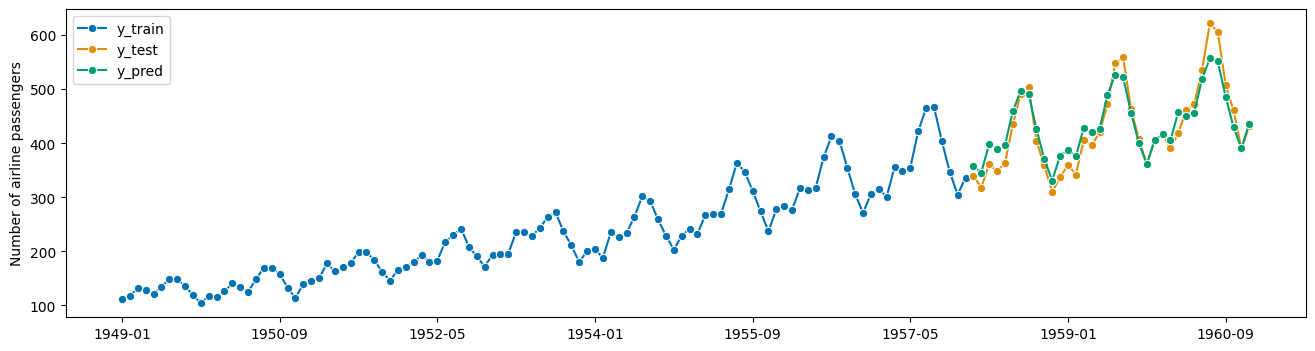

In [178]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

The exponential smoothing of state space model can also be automated similar
 to the [ets](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/ets) function in R. This is implemented in the `AutoETS` forecaster.

In [179]:
from sktime.forecasting.ets import AutoETS

0.06186354612548242

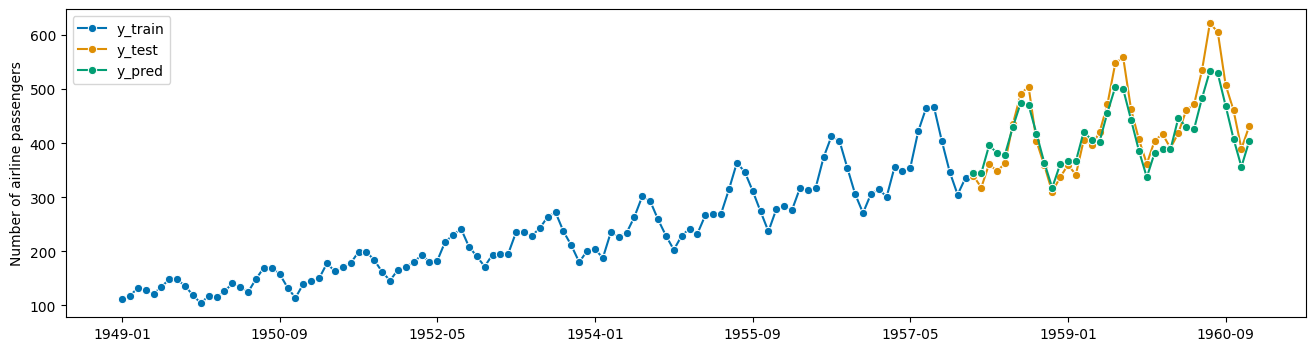

In [180]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [181]:
# todo: explain Theta; explain how to get theta-lines

### 2.3.2 ARIMA and autoARIMA<a class="anchor" id="section_2_3_2"></a>

`sktime` interfaces `pmdarima` for its ARIMA class models.
For a classical ARIMA model with set parameters, use the `ARIMA` forecaster:

In [182]:
from sktime.forecasting.arima import ARIMA

0.04356744949188808

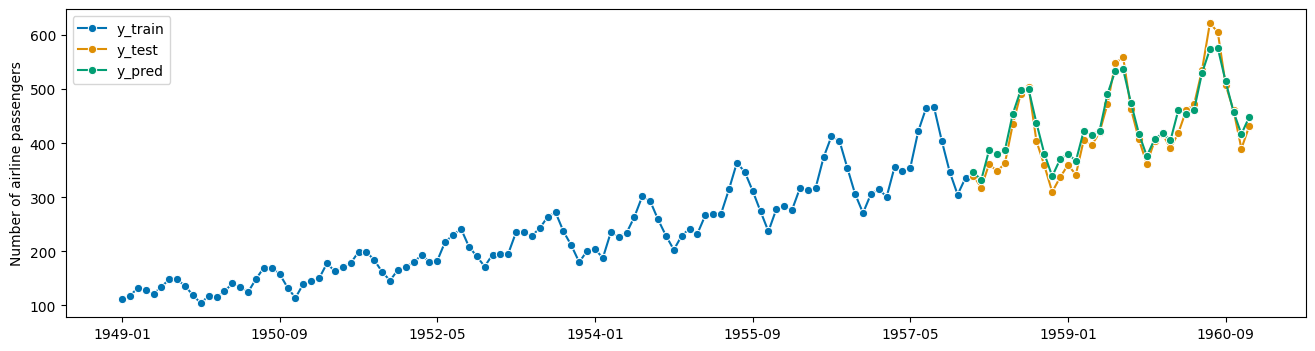

In [183]:
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

`AutoARIMA` is an automatically tuned `ARIMA` variant that obtains the optimal pdq parameters automatically:

In [184]:
from sktime.forecasting.arima import AutoARIMA

0.04148971434138202

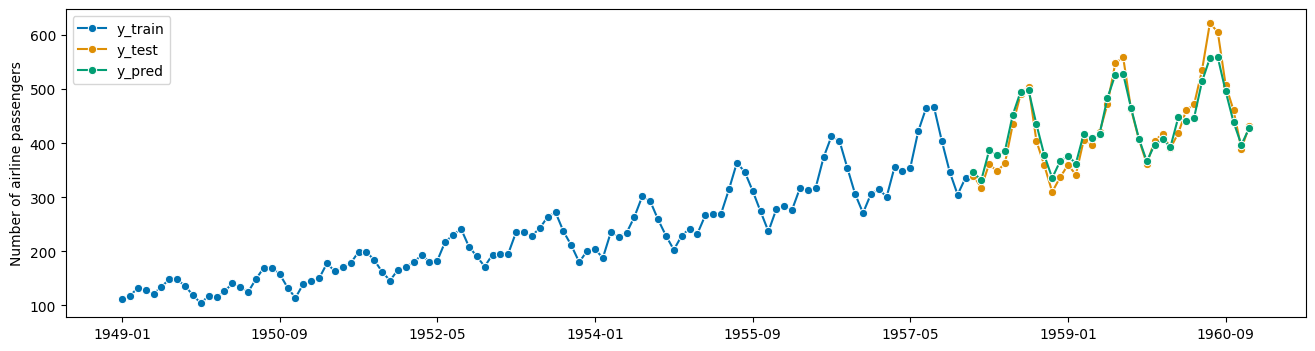

In [185]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.04093675930591672

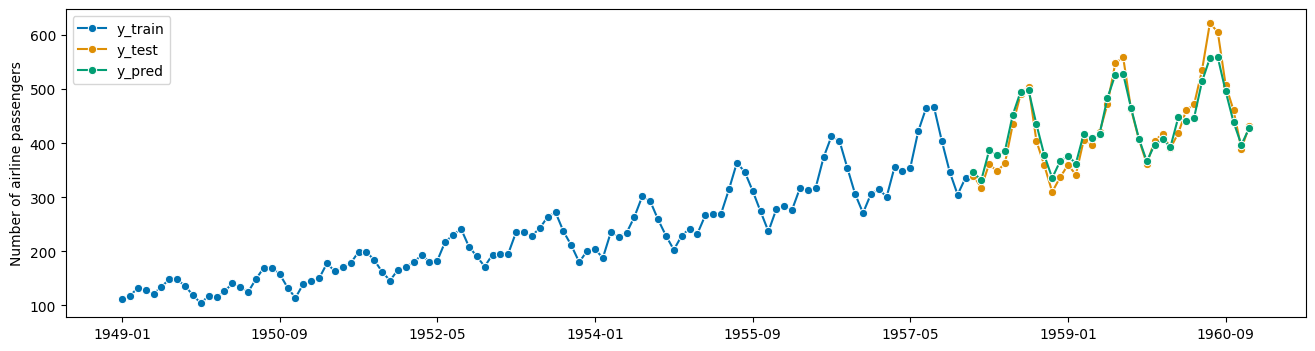

In [186]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [187]:
# to obtain the fitted parameters, run
forecaster.get_fitted_params()
# should these not include pdq?

{'ar.L1': -0.2411177593160947,
 'sigma2': 92.74985957133522,
 'order': (1, 1, 0),
 'seasonal_order': (0, 1, 0, 12),
 'aic': 704.0011679025909,
 'aicc': 704.1316026851996,
 'bic': 709.108921685792,
 'hqic': 706.0650836395923}

### 2.3.3 BATS and TBATS<a class="anchor" id="section_2_3_3"></a>

`sktime` interfaces BATS and TBATS from the [`tbats`](https://github.com/intive-DataScience/tbats) package.

In [188]:
from sktime.forecasting.bats import BATS

0.08185559475988374

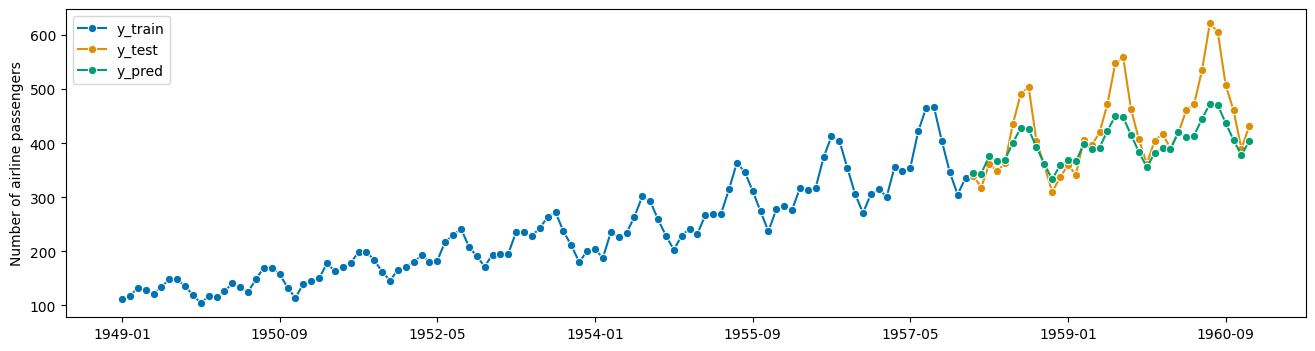

In [190]:
forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [191]:
from sktime.forecasting.tbats import TBATS

0.08024090844021758

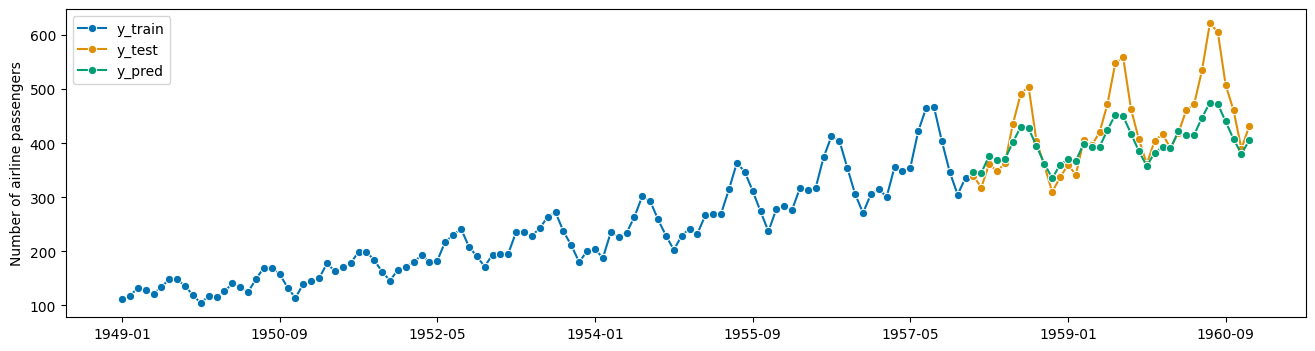

In [192]:
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### 2.3.4 Facebook prophet<a class="anchor" id="section_2_3_4"></a>

`sktime` provides an interface to [`fbprophet`](https://github.com/facebook/prophet) by Facebook.

In [ ]:
from sktime.forecasting.fbprophet import Prophet

The current interface does not support period indices, only pd.DatetimeIndex. Consider improving this by contributing the `sktime`.

In [193]:
# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)

In [194]:
forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

NameError: name 'Prophet' is not defined

### 2.3.5 State Space Model (Structural Time Series)<a class="anchor" id="section_2_3_5"></a>

We can also use the [`UnobservedComponents`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html) class from [`statsmodels`](https://www.statsmodels.org/stable/index.html) to generate predictions using a state space model.

In [ ]:
from sktime.forecasting.structural import UnobservedComponents

0.0497366365924174

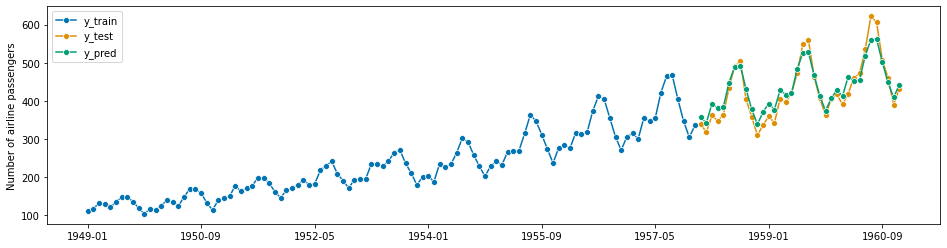

In [ ]:
# We can model seasonality using Fourier modes as in the Prophet model.
forecaster = UnobservedComponents(
    level="local linear trend", freq_seasonal=[{"period": 12, "harmonics": 10}]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### 2.3.6 AutoARIMA from [StatsForecast](https://github.com/Nixtla/statsforecast)<a class="anchor" id="section_2_3_6"></a>

`sktime` interfaces `StatsForecast` for its `AutoARIMA` class models. `AutoARIMA` is an automatically tuned `ARIMA` variant that obtains the optimal pdq parameters automatically:

In [ ]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

0.04093539044441262

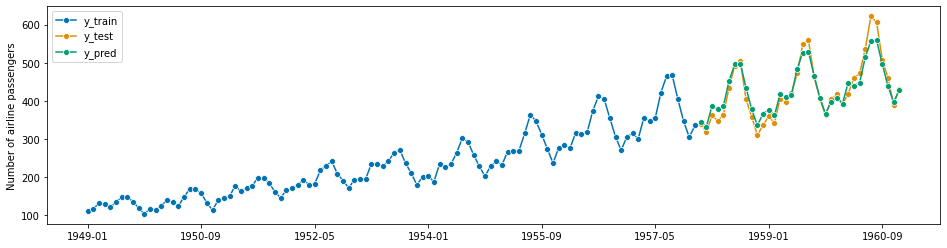

In [ ]:
forecaster = StatsForecastAutoARIMA(sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## 3. Advanced composition patterns - pipelines, reduction, autoML, and more<a class="anchor" id="chapter3"></a>

`sktime` supports a number of advanced composition patterns to create forecasters out of simpler components:

* Reduction - building a forecaster from estimators of "simpler" scientific types, like `scikit-learn` regressors. A common example is feature/label tabulation by rolling window, aka the "direct reduction strategy".
* Tuning - determining values for hyper-parameters of a forecaster in a data-driven manner. A common example is grid search on temporally rolling re-sampling of train/test splits.
* Pipelining - concatenating transformers with a forecaster to obtain one forecaster. A common example is detrending and deseasonalizing then forecasting, an instance of this is the common "STL forecaster".
* AutoML, also known as automated model selection - using automated tuning strategies to select not only hyper-parameters but entire forecasting strategies. A common example is on-line multiplexer tuning.

For illustration, all estimators below will be presented on the basic forecasting workflow - though they also support the advanced forecasting and evaluation workflows under the unified `sktime` interface (see Section 1).

For use in the other workflows, simply replace the "forecaster specification block" ("`forecaster=`") by the forecaster specification block in the examples presented below.

In [ ]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

### 3.1 Reduction: from forecasting to regression<a class="anchor" id="section_3_1"></a>

`sktime` provides a meta-estimator that allows the use of any `scikit-learn` estimator for forecasting.

* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **parametric** and **tuneable**, allowing us to tune hyper-parameters such as the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

**Example**: we will define a tabulation reduction strategy to convert a k-nearest neighbors regressor (`sklearn` `KNeighborsRegressor`) into a forecaster. The composite algorithm is an object compliant with the `sktime` forecaster interface (picture: big robot), and contains the regressor as a parameter accessible component (picture: little robot). In `fit`, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data (picture: left half). In `predict`, the composite algorithm presents the regressor with the last observed window to obtain predictions (picture: right half).

<img src="img/forecasting-to-regression-reduction.png" width="500"/>

Below, the composite is constructed using the shorthand function `make_reduction` which produces a `sktime` estimator of forecaster scitype. It is called with a constructed `scikit-learn` regressor, `regressor`, and additional parameter which can be later tuned as hyper-parameters

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

In [ ]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

0.12887507224382988

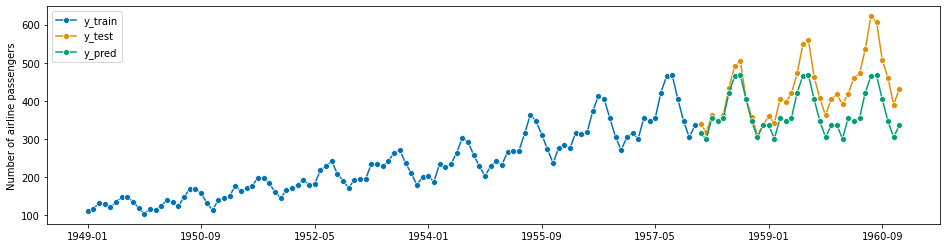

In [ ]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In the above example we use the "recursive" reduction strategy. Other implemented strategies are: 
* "direct", 
* "dirrec", 
* "multioutput". 

Parameters can be inspected using `scikit-learn` compatible `get_params` functionality (and set using `set_params`). This provides tunable and nested access to parameters of the `KNeighborsRegressor` (as `estimator_etc`), and the `window_length` of the reduction strategy. Note that the `strategy` is not accessible, as underneath the utility function this is mapped on separate algorithm classes. For tuning over algorithms, see the "autoML" section below. 

In [ ]:
forecaster.get_params()

{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(n_neighbors=1),
 'transformers': None,
 'window_length': 15}

### 3.2 Pipelining, detrending and deseasonalization<a class="anchor" id="section_3_2"></a>

A common composition motif is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data. 

#### 3.2.1 The basic forecasting pipeline<a class="anchor" id="section_3_2_1"></a>

`sktime` provides a generic pipeline object for this kind of composite modelling, the `TransforemdTargetForecaster`. It chains an arbitrary number of transformations with a forecaster. The transformations should be instances of estimators with series-to-series-transformer scitype. An example of the syntax is below:

In [198]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.func_transform import FunctionTransformer

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

NameError: name 'y_train' is not defined

The `TransformedTargetForecaster` is constructed with a list of steps, each a pair of name and estimator. The estimators should be series-to-series transformers which possess both a `transform` and `inverse_transform` method. The resulting estimator is of forecaster scitype and has all interface defining methods. In `fit`, all transformers apply `fit_transforms` to the data, then the forecaster's `fit`; in `predict`, first the forecaster's `predict` is applied, then the transformers' `inverse_transform` in reverse order.

The same pipeline, as above, can also be constructed with the multiplication dunder method `*`.

This creates a `TransformedTargetForecaster` as above, with components given default names.

In [197]:
forecaster = Deseasonalizer(model="multiplicative", sp=12) * ARIMA()
forecaster

NameError: name 'FunctionTransformer' is not defined

The names in a dunder constructed pipeline are made unique in case, e.g., two deseasonalizers are used.

Example of a multiple seasonality model with rounding postprocessing of the predictions:

In [204]:
forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * ARIMA()
    # * FunctionTransformer(lambda y: y.round())
)

forecaster.get_params()
forecaster.fit_predict(y, fh=fh)

1958-01    341.424578
1958-02    329.286014
1958-03    361.729605
1958-04    351.914312
1958-05    349.155743
1958-06    410.672432
1958-07    481.079229
1958-08    487.137952
1958-09    437.936563
1958-10    352.335348
1958-11    311.282802
1958-12    346.971029
1959-01    342.439052
1959-02    348.623789
1959-03    388.983248
1959-04    394.615281
1959-05    397.231846
1959-06    475.050847
1959-07    521.934278
1959-08    543.602448
1959-09    484.695762
1959-10    403.707253
1959-11    352.836859
1959-12    405.080002
1960-01    411.423287
1960-02    403.736449
1960-03    444.626104
1960-04    407.231476
1960-05    462.334902
1960-06    533.782031
1960-07    591.498279
1960-08    616.907233
1960-09    525.393583
1960-10    442.889214
1960-11    399.585172
1960-12    436.369449
Freq: M, dtype: float64

#### 3.2.2 The `Detrender` as pipeline component<a class="anchor" id="section_3_2_2"></a>

For detrending, we can use the `Detrender`. This is an estimator of series-to-transformer scitype that wraps an arbitrary forecaster. For example, for linear detrending, we can use `PolynomialTrendForecaster` to fit a linear trend, and then subtract/add it using the `Detrender` transformer inside `TransformedTargetForecaster`.

To understand better what happens, we first examine the detrender separately:

In [ ]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

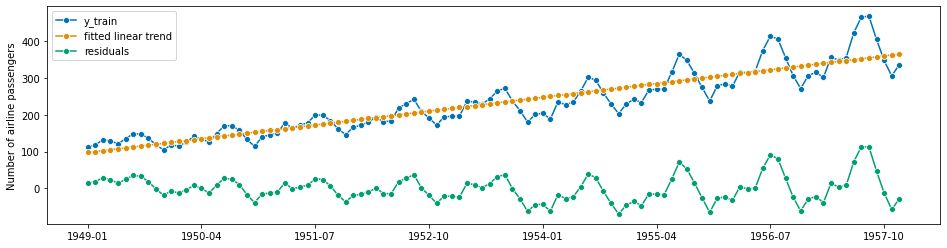

In [ ]:
# linear detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

Since the `Detrender` is of scitype series-to-series-transformer, it can be used in the `TransformedTargetForecaster` for detrending any forecaster:

0.05610168219854761

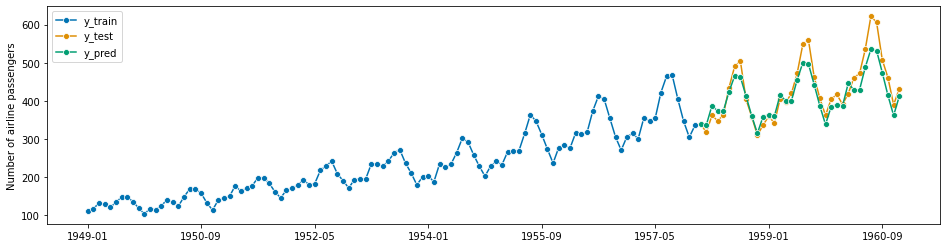

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

#### 3.2.3 Complex pipeline composites and parameter inspection<a class="anchor" id="section_3_2_3"></a>

`sktime` follows the `scikit-learn` philosophy of composability and nested parameter inspection. As long as an estimator has the right scitype, it can be used as part of any composition principle requiring that scitype. Above, we have already seen the example of a forecaster inside a `Detrender`, which is an estimator of scitype series-to-series-transformer, with one component of forecaster scitype. Similarly, in a `TransformedTargetForecaster`, we can use the reduction composite from Section 3.1 as the last forecaster element in the pipeline, which inside has an estimator of tabular regressor scitype, the `KNeighborsRegressor`:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

0.058708387889316475

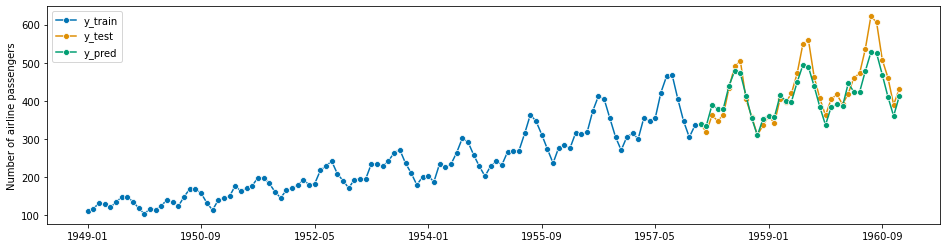

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

As with `scikit-learn` models, we can inspect and access parameters  of any component via `get_params` and `set_params`:

In [ ]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=15))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=15),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params': None,
 'forecast__estimator__n

### 3.3 Parameter tuning<a class="anchor" id="section_3_3"></a>

`sktime` provides parameter tuning strategies as compositors of forecaster scitype, similar to `scikit-learn`'s `GridSearchCV`.

### 3.3.1 Basic tuning using `ForecastingGridSearchCV`<a class="anchor" id="section_3_3_1"></a>

The compositor `ForecastingGridSearchCV` (and other tuners) are constructed with a forecaster to tune, a cross-validation constructor, a `scikit-learn` parameter grid, and parameters specific to the tuning strategy. Cross-validation constructors follow the `scikit-learn` interface for re-samplers, and can be slotted in exchangeably.

As an example, we show tuning of the window length in the reduction compositor from Section 3.1, using temporal sliding window tuning:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

As with other composites, the resulting forecaster provides the unified interface of `sktime` forecasters - window splitting, tuning, etc requires no manual effort and is done behind the unified interface:

0.16607972017556033

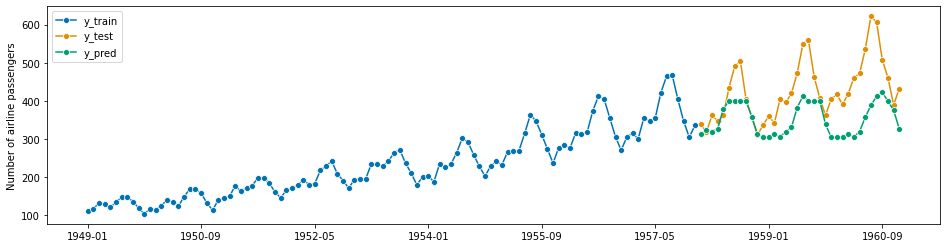

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

Tuned parameters can be accessed in the `best_params_` attribute:

In [ ]:
gscv.best_params_

{'window_length': 7}

An instance of the best forecaster, with hyper-parameters set, can be retrieved by accessing the `best_forecaster_` attribute:

In [ ]:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=7)

### 3.3.2 Tuning of complex composites<a class="anchor" id="section_3_3_2"></a>

As in `scikit-learn`, parameters of nested components can be tuned by accessing their `get_params` key - by default this is `[estimatorname]__[parametername]` if `[estimatorname]` is the name of the component, and `[parametername]` the name of a parameter within the estimator `[estimatorname]`. 

For example, below we tune the `KNeighborsRegressor` component's `n_neighbors`, in addition to tuning `window_length`. The tuneable parameters can easily be queried using `forecaster.get_params()`.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
param_grid = {"window_length": [7, 12, 15], "estimator__n_neighbors": np.arange(1, 10)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

0.13988948769413537

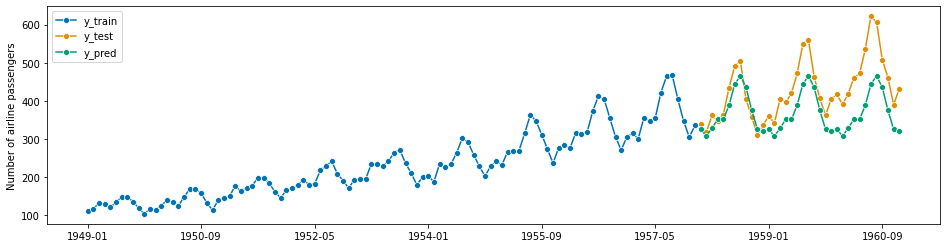

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.best_params_

{'estimator__n_neighbors': 2, 'window_length': 12}

An alternative to the above is tuning the regressor separately, using `scikit-learn`'s `GridSearchCV` and a separate parameter grid. As this does not use the "overall" performance metric to tune the inner regressor, performance of the composite forecaster may vary.

In [ ]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_neighbors": np.arange(1, 10)}
forecaster_param_grid = {"window_length": [7, 12, 15]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(KNeighborsRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.14493362646957736

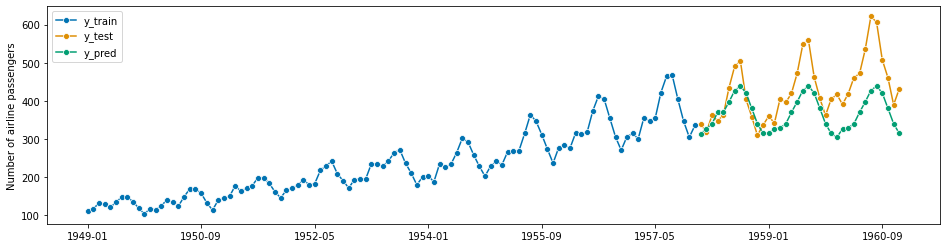

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

NOTE: a smart implementation of this would use caching to save partial results from the inner tuning and reduce runtime substantially - currently `sktime` does not support this. Consider helping to improve `sktime`.

### 3.3.3 Selecting the metric and retrieving scores<a class="anchor" id="section_3_3_3"></a>

All tuning algorithms in `sktime` allow the user to set a score; for forecasting the default is mean absolute percentage error. The score can be set using the `score` argument, to any scorer function or class, as in Section 1.3.

Re-sampling tuners retain performances on individual forecast re-sample folds, which can be retrieved from the `cv_results_` argument after the forecaster has been fit via a call to `fit`.

In the above example, using the mean squared error instead of the mean absolute percentage error for tuning would be done by defining the forecaster as follows:

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError

In [ ]:
mse = MeanSquaredError()

param_grid = {"window_length": [7, 12, 15]}

regressor = KNeighborsRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=mse)

The performances on individual folds can be accessed as follows, after fitting:

In [ ]:
gscv.fit(y_train)
gscv.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,2600.750255,0.051403,0.002837,{'window_length': 7},3.0
1,1134.999053,0.051353,0.002975,{'window_length': 12},1.0
2,1285.133614,0.050748,0.003272,{'window_length': 15},2.0


###  3.4 autoML  aka automated model selection, ensembling and hedging<a class="anchor" id="section_3_4"></a>

`sktime` provides a number of compositors for ensembling and automated model selection. In contrast to tuning, which uses data-driven strategies to find optimal hyper-parameters for a fixed forecaster, the strategies in this section combine or select on the level of estimators, using a collection of forecasters to combine or select from.

The strategies discussed in this section are:
* autoML aka automated model selection
* simple ensembling
* prediction weighted ensembles with weight updates, and hedging strategies

###  3.4.1 autoML aka automatic model selection, using tuning plus multiplexer<a class="anchor" id="section_3_4_1"></a>

The most flexible way to perform model selection over forecasters is by using the `MultiplexForecaster`, which exposes the choice of a forecaster from a list as a hyper-parameter that is tunable by generic hyper-parameter tuning strategies such as in Section 3.3.

In isolation, `MultiplexForecaster` is constructed with a named list `forecasters`, of forecasters. It has a single hyper-parameter, `selected_forecaster`, which can be set to the name of any forecaster in `forecasters`, and behaves exactly like the forecaster keyed in `forecasters` by `selected_forecaster`.

In [ ]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

In [ ]:
forecaster.set_params(**{"selected_forecaster": "naive"})
# now forecaster behaves like NaiveForecaster(strategy="last")

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

In [ ]:
forecaster.set_params(**{"selected_forecaster": "ets"})
# now forecaster behaves like ExponentialSmoothing(trend="add", sp=12))

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='ets')

The `MultiplexForecaster` is not too useful in isolation, but allows for flexible autoML when combined with a tuning wrapper. The below defines a forecaster that selects one of `NaiveForecaster` and `ExponentialSmoothing` by sliding window tuning as in Section 3.3.

Combined with rolling use of the forecaster via the `update` functionality (see Section 1.4), the tuned multiplexer can switch back and forth between `NaiveForecaster` and `ExponentialSmoothing`, depending on performance, as time progresses.

In [ ]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ]
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)
forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.19886711926999853

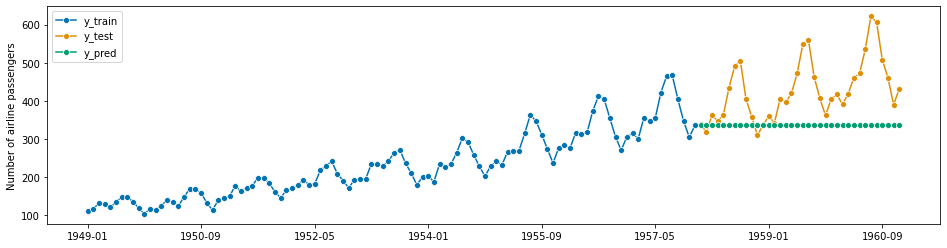

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

As with any tuned forecaster, best parameters and an instance of the tuned forecaster can be retrieved using `best_params_` and `best_forecaster_`:

In [ ]:
gscv.best_params_

{'selected_forecaster': 'naive'}

In [ ]:
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

### 3.4.2 autoML: selecting transformer combinations via `OptimalPassthrough`<a class="anchor" id="section_3_4_2"></a>

`sktime` also provides capabilities for automated selection of pipeline components *inside* a pipeline, i.e., pipeline structure. This is achieved with the `OptionalPassthrough` transformer.

The `OptionalPassthrough` transformer allows to tune whether a transformer inside a pipeline is applied to the data or not. For example, if we want to tune whether `sklearn.StandardScaler` is bringing an advantage to the forecast or not, we wrap it in `OptionalPassthrough`. Internally, `OptionalPassthrough` has a hyperparameter `passthrough: bool` that is tuneable; when `False` the composite behaves like the wrapped transformer, when `True`, it ignores the transformer within.

To make effective use of `OptionalPasstrhough`, define a suitable parameter set using the `__` (double underscore) notation familiar from `scikit-learn`. This allows to access and tune attributes of nested objects like TabularToSeriesAdaptor(StandardScaler()). We can use `__` multiple times if we have more than two levels of nesting.

In the following example, we take a deseasonalize/scale pipeline and tune over the four possible combinations of deseasonalizer and scaler being included in the pipeline yes/no (2 times 2 = 4); as well as over the forecaster's and the scaler's parameters.

Note: this could be arbitrarily combined with `MultiplexForecaster`, as in Section 3.4.1, to select over pipeline architecture as well as over pipeline structure.

Note: `scikit-learn` and `sktime` do not support conditional parameter sets at current (unlike, e.g., the `mlr3` package). This means that the grid search will optimize over the `scaler`'s parameters even when it is skipped. Designing/implementing this capability would be an interesting area for contributions or research.

In [ ]:
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [ ]:
# create pipeline
pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", NaiveForecaster()),
    ]
)

# putting it all together in a grid search
cv = SlidingWindowSplitter(
    initial_window=60, window_length=24, start_with_window=True, step_length=24
)
param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "scaler__transformer__transformer__with_mean": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__strategy": ["drift", "mean", "last"],
}
gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)

0.1299046419013891

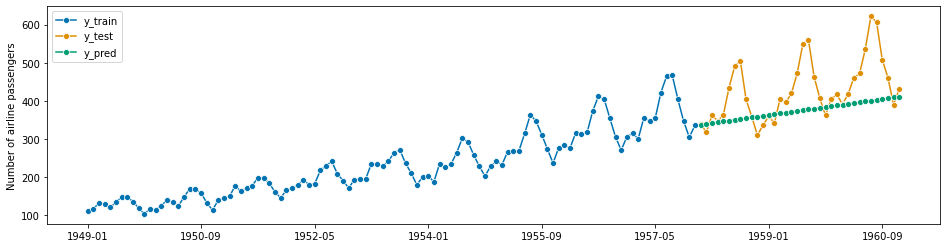

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

###  3.4.3 Simple ensembling strategies<a class="anchor" id="section_3_4_3"></a>

TODO - contributions in this section are appreciated

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster

0.16617968035655875

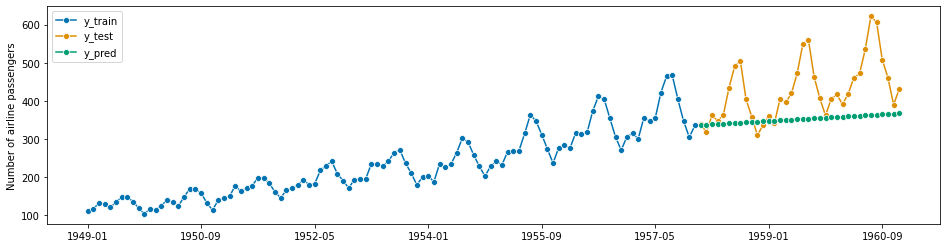

In [ ]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### 3.4.4 Prediction weighted ensembles and hedge ensembles<a class="anchor" id="section_3_4_4"></a>

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, we can leverage the forecasters from the `online_forecasting` module which use a composite forecaster, `PredictionWeightedEnsemble`, to keep track of the loss accumulated by each forecaster and create a prediction weighted by the predictions of the most "accurate" forecasters.

Note that the forecasting task is changed: we make 35 predictions since we need the first prediction to help update the weights, we do not predict 36 steps ahead.

In [ ]:
from sktime.forecasting.all import mean_squared_error
from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)

First we need to initialize a `PredictionWeightedEnsembler` that will keep track of the loss accumulated by each forecaster and define which loss function we would like to use.

In [ ]:
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

We can then create the forecaster by defining the individual forecasters and specifying the `PredictionWeightedEnsembler` we are using. Then by fitting our forecasters and performing updates and prediction with the `update_predict` function, we get:

0.0978975689038194

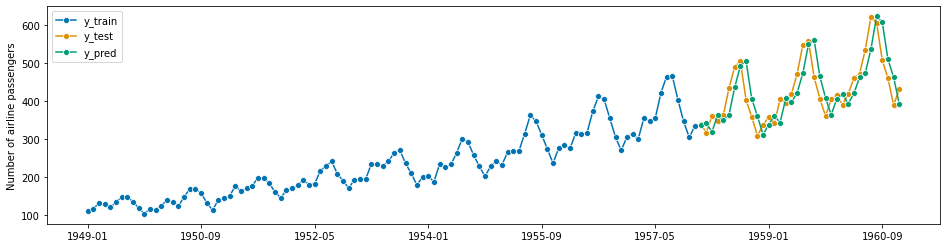

In [ ]:
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ],
    ensemble_algorithm=hedge_expert,
)

forecaster.fit(y=y_train, fh=fh)
y_pred = forecaster.update_predict_single(y_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## 4. Extension guide - implementing your own forecaster<a class="anchor" id="chapter4"></a>

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To get started:

* Follow the ["implementing estimator" developer guide](https://www.sktime.org/en/stable/developer_guide/add_estimators.html)
* Use the [simple forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting_simple.py) for forecasters without stream, probabilistic, or hierarchical functionality
* Use the [advanced forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting.py) for forecasters with stream, probabilistic or hierarchical functionality
* For probabilistic and hierarchical forecasters, it is recommended to familiarize yourself with the interfaces via the tutorials

1. Read through the [forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. Optionally, if you are planning any major surgeries to the interface: look at the [base class architecture](https://github.com/sktime/sktime/blob/main/sktime/forecasting/base/_base.py) - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. Copy the forecasting extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.forecasting`; rename the file and update the file docstring appropriately.
4. Address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_predict`, and optional methods such as `_update` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. To test your estimator manually: import your estimator and run it in the worfklows in Section 1; then use it in the compositors in Section 3.
6. To test your estimator automatically: call `sktime.utils.estimator_checks.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* Add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* Create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* In the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* Before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 5. Summary<a class="anchor" id="chapter5"></a>

* `sktime` comes with several forecasting algorithms (or forecasters), all of which share a common interface. The interface is fully interoperable with the `scikit-learn` interface, and provides dedicated interface points for forecasting in batch and rolling mode.

* `sktime` comes with rich composition functionality that allows to build complex pipelines easily, and connect easily with other parts of the open source ecosystem, such as `scikit-learn` and individual algorithm libraries.

* `sktime` is easy to extend, and comes with user friendly tools to facilitate implementing and testing your own forecasters and composition principles.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).

---

### Credits:

sktime: https://github.com/sktime/sktime/blob/main/CONTRIBUTORS.md